In [1]:
#!/usr/bin/env python3

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import copy
import cma
import math
from sklearn.metrics import mean_squared_error

#removes first N-1 items of the list
def moving_average(time_series, N):
    return np.convolve(time_series, np.ones((N,))/N)[(N-1):]


#Differential equations of the model
def deriv(Price0, t, limit, alpha):
    Price = Price0
    dPricedt =(1 - Price/limit)*Price*alpha
    return dPricedt

def simulation(params):
    x0 =params[0]
    limit = params[1]
    alpha=params[2]
    t_max = params[3]
    t = range(0, t_max)
    ret = odeint(deriv, x0, t, args=(limit, alpha))
    return ret.T[0]


In [2]:
def converse(n, v0):
	return v0 + n*10


def deconverse(num, v0):
	return (num-v0)/10

#removes first N-1 items of the list
def moving_average(time_series, N):
    return np.convolve(time_series, np.ones((N,))/N)[(N-1):]

def readData(filename):
        file = open(filename, "r")
        data1 =  file.read().splitlines()
        data2 = [float(x) for x in data1]
        return data2


In [3]:
class DESimulator:
    def __init__(self, realdata):
        self.realdata = realdata
        self.es = cma.CMAEvolutionStrategy(4*[0], 0.5)

    def run(self, sigma, sigma0):
        #print("Recebi {} valores em sigma".format(len(sigma)))
        best = cma.fmin(self.objective_function, sigma, sigma0)[0]
        return best

    def objective_function(self, *args):
        y0, alpha, beta, limit = args[0]
        y0 = math.fabs(converse(y0, 65))
        limit = math.fabs(converse(limit, 210))
        t = range(0, len(self.realdata))
        #print(f"----> Recebi params para avaliar: {y0},{alpha},{beta},{limit}")
        ret = odeint(self.deriv_limits_to_grow, y0, t, args=(math.fabs(alpha), math.fabs(beta), limit))
        result = ret.T[0]
        rmse = math.sqrt(mean_squared_error(result, self.realdata))
        return rmse

    def deriv_limits_to_grow(self, y, t, alpha, beta, limit):
        Price = y
        dPricedt = alpha*Price - beta*Price*Price/limit
        return dPricedt	

    def simulate(self, params, t):
        #print(f"Recebi Params: {params}")
        y0 = params[0]
        alpha = params[1]
        beta = params[2]
        limit = params[3]
        t = range(0, t)
        ret = odeint(self.deriv_limits_to_grow, y0, t, args=(math.fabs(alpha), math.fabs(beta), limit))
        result = ret.T[0]
        return result
    
    def run_mc(self, params_initial):
        #print("Recebi {} valores params_mc".format(params_initial))
        params_initial[0] = math.fabs(deconverse(params_initial[0], 65))
        params_initial[3] = math.fabs(deconverse(params_initial[3], 210))
        likelihood = float(1/self.objective_function(params_initial))
        new_likelihood = likelihood
        best_params = params_initial
        params = params_initial
        counter = 0
        max_total_cycles = 10000
        total_cycles = 0
        best_likelihood = 0
        while counter < 10 and total_cycles < max_total_cycles:
            if (likelihood >= best_likelihood):
                best_likelihood = likelihood
            if(new_likelihood >= likelihood):
                #print(f"New likelihood: {new_likelihood} > likelihood {likelihood}")
                likelihood = new_likelihood
                params = self.findNeighbour(params)
                new_likelihood =  float(1/self.objective_function(params))
                counter = 0
                if(new_likelihood >= best_likelihood):
                    best_params = params
            else:
                prob = np.random.random(1)
                acceptance_ratio = new_likelihood/likelihood
                if(prob<= acceptance_ratio):
                    likelihood = new_likelihood
                    params =self.findNeighbour(params)
                    new_likelihood = float(1/self.objective_function(params))
            counter += 1
            total_cycles += 1
            print(f"Counter: {counter}")
        return best_params
              
              
              
    def findNeighbour(self, params):
        new_params = []
      #  params[0] = math.fabs(deconverse(params[0], 65))
      #  params[3] = math.fabs(deconverse(params[3], 210))
    
        for p in params:
            while True:
            #Mudar aqui para int, senao muda muito pouco de uma rodada para a outra
                new_p = np.random.normal(loc=p, scale=p/10.00, size=None)
                if new_p != p:
                    new_params.append(new_p)
                    break
        #print(f"Old Params {params}, new params: {new_params}")
       # new_params[0] = math.fabs(converse(new_params[0], 65))
        #new_params[3] = math.fabs(converse(new_params[3], 210))
        return new_params


    



In [4]:
class Buyer:
    def __init__(self, savings, price, inflation):
        self.savings = savings
        self.lastPrice = price
        self.inflation = inflation
        self.askedPrice = self.lastPrice
        self.expected_quality = 1 + np.random.pareto(10) * inflation
        self.noBuy = 0

    def counterpropose(self):
        #self.offeredPrice = float(self.lastPrice + (self.askedPrice - self.lastPrice)*self.askedPrice/self.savings )
        self.offeredPrice = self.lastPrice * (1 + self.inflation)
        #self.offeredPrice = float(self.lastPrice + (self.savings - self.askedPrice/2)*self.savings/self.askedPrice)
        #self.bargain = float(self.inflation * self.lastPrice * self.lastPrice/self.savings)
        #self.offeredPrice = float(self.lastPrice + (self.inflation * self.lastPrice - self.bargain))
        return min(self.savings, self.offeredPrice)


class Seller:
    def __init__(self, expectation, price):
        self.price = price
        self.expectation = expectation
        self.quality = 1 + np.random.pareto(10) * expectation
        self.noSell = 0
        self.lower_price = 0.9
        self.max_noSell = 1 + np.random.randint(3)
        
    def calculatesPrice(self):
        self.lower_price = self.price * (1 + self.expectation/5)
        self.price = self.price * (1 + self.expectation)

        #print "New price: "+ str(self.price)
        #print "Lower price: "+str(self.lower_price)

    def recalculatePrice(self):
        if(self.noSell >= self.max_noSell):
            self.price = self.lower_price
            self.lower_price = self.lower_price * (1 - self.expectation/5)

            #self.price = self.price * (1 - self.expectation/3)
            #self.lower_price = self.price * (1 - 0.05)
            #print "Lower price: " + str(self.price)
            self.noSell = 0
        else:
            self.noSell += 1


In [ ]:
class ABSimulator:
    def __init__(self, realdata):
        self.realdata = realdata
        self.es = cma.CMAEvolutionStrategy(4*[0], 0.5)
        self.best_sim = []
        self.best_rmse = 0


    def calibrate(self, sigma, sigma0):
        #print("Recebi {} valores em sigma".format(len(sigma)))
        best = cma.fmin(self.objective_function, sigma, sigma0)[0]
        return best

    def findNeighbour(self, params):
        new_params = []
      #  params[0] = math.fabs(deconverse(params[0], 65))
      #  params[3] = math.fabs(deconverse(params[3], 210))
    
        for p in params:
            while True:
            #Mudar aqui para int, senao muda muito pouco de uma rodada para a outra
                new_p = np.random.normal(loc=p, scale=p/10.00, size=None)
                if new_p != p:
                    new_params.append(new_p)
                    break
        #print(f"Old Params {params}, new params: {new_params}")
       # new_params[0] = math.fabs(converse(new_params[0], 65))
        #new_params[3] = math.fabs(converse(new_params[3], 210))
        return new_params


    def monteCarlo(self, params_initial):
        #likelihood =  float(1/math.sqrt(mean_squared_error(self.realdata, self.simulate(params_initial))))
        likelihood = float(1/self.objective_function(params_initial))
        #print(f"Likelihood: {likelihood}")
        new_likelihood = likelihood
        best_params = params_initial
        params = params_initial
        counter = 0
        max_total_cycles = 10000
        total_cycles = 0
        best_likelihood = 0
        while counter < 10 and total_cycles < max_total_cycles:
            if (likelihood >= best_likelihood):
                best_likelihood = likelihood
            if(new_likelihood >= likelihood):
                #print(f"New likelihood: {new_likelihood} > likelihood {likelihood}")
                likelihood = new_likelihood
                params = self.findNeighbour(params)
                new_likelihood =  float(1/self.objective_function(params_initial))
                counter = 0
                if(new_likelihood >= best_likelihood):
                    best_params = params
            else:
                prob = np.random.random(1)
                acceptance_ratio = new_likelihood/likelihood
                if(prob<= acceptance_ratio):
                    likelihood = new_likelihood
                    params =self.findNeighbour(params)
                    new_likelihood = float(1/self.objective_function(params_initial))
            counter += 1
            total_cycles += 1
            print(f"Counter: {counter}")
        return best_params

    def createPopulation(self, n, params):
        buyers = []
        sellers = []
        limit = math.fabs(params[0])
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        price0 = math.fabs(params[3])
        for i in range(n):
            l = np.random.normal(loc=limit, scale=limit/10.00, size=None)
            #a = np.random.normal(loc=alpha, scale=alpha/10.00, size=None)
            #Generates a fat-tailed distribution (on both tails) for the limit
            a = limit + np.random.standard_t(3)
            b = np.random.normal(loc=beta, scale=beta/10.00, size=None)
            seller = Seller(b, price0)
            seller.calculatesPrice()
            sellers.append(seller)
            buyer = Buyer(l, price0, a)
            buyers.append(buyer)
        return sellers, buyers



    def simulate(self, params):
        price0 = math.fabs(converse(params[0], 65))
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        limit = math.fabs(converse(params[3], 210))
        #print("----> Params MABS: {},{},{}, {}".format(price0, alpha, beta, limit))

        average_price = 0
        sold = 0
        sum_price = 0
        sold_price = 0

        buyers = []
        sellers = []

        price_time_series = [price0]

        params = [limit, alpha, beta, price0]

        population_size = 5
        sellers, buyers = self.createPopulation(population_size, params)

        sellers = sorted(sellers, key=lambda seller: seller.expectation)
        buyers = sorted(buyers, key=lambda buyer: buyer.savings)

        average_price_time_series = [price0]
        average_price = 0
        sold =0

        sellers_id = [x for x in range(len(sellers)) ]
        active_sellers = copy.copy(sellers)


        #print("========================================= ABS Sim ====================================")

        for t in range(125):
            active_sellers = copy.copy(sellers_id)
            for buyer in buyers:
                for id in active_sellers:
                    seller = sellers[id]
                    charged_price = seller.price
                    buyer.askedPrice = charged_price
                    if(charged_price <= 2* buyer.savings):
                        proposed_price = buyer.counterpropose()
                        if (proposed_price >= seller.lower_price): 
                            sold_price = min(proposed_price, seller.price)
                            buyer.lastPrice = sold_price
                            seller.price = sold_price
                            seller.calculatesPrice()
                            sold+= 1
                            sum_price = sum_price + sold_price
                            active_sellers.remove(id)
                            break
                        else:
                            seller.noSell+= 1
            for seller in sellers:
                seller.recalculatePrice()
            if(sold!=0):
                average_price = float(sum_price/ sold)
            else:
                average_price = 0		
            average_price_time_series.append(average_price)
            sold = 0
            sum_price = 0

        simdata= moving_average(average_price_time_series, 3)
        return simdata[:len(simdata)-3]


    def objective_function(self, *args):
        y0, alpha, beta, limit = args[0]
        y0 = math.fabs(deconverse(y0, 65))
        limit = math.fabs(deconverse(limit, 210))
        t = range(0, len(self.realdata))
        result =  self.simulate([y0, alpha, beta, limit])
        rmse = math.sqrt(mean_squared_error(result, self.realdata))
        if(self.best_rmse == 0 or rmse <= self.best_rmse):
            self.best_rmse = rmse
            self.best_sim = result
        return rmse





In [ ]:
def main():

    average_price = 0
    sold = 0
    sum_price = 0
    sold_price = 0


    buyers = []
    sellers = []
    best_mrse = 0
    best_sim = []
    realdata = readData("sp")
    t = len(realdata)
    
    #Initializing the parameters with most plausiblre values
    price0= min(realdata)
    limit = max(realdata)
    alpha = 0.05
    beta = 0.03
    price_time_series = [price0]
    
#normalizing values as price0 and limit are orders of magnitude greater than alpha and beta parameters
    price0_norm = math.fabs(deconverse(price0, 65))
    limit_norm = math.fabs(deconverse(limit, 210))
    sigma=[price0_norm, alpha, beta, limit_norm]

    
    
#Find best parameters for the ODE based on real data - CMA-ES strategy
    #surrogate_simulator = DESimulator(realdata)
    #cma_surrogate_data = surrogate_simulator.run(sigma=[price0_norm, alpha, beta, limit_norm], sigma0=0.02)
    #cma_surrogate_data = [converse(cma_surrogate_data[0], 65), cma_surrogate_data[1], cma_surrogate_data[2], converse(cma_surrogate_data[3], 210)]
    #print(f"Params: {cma_surrogate_data}")
    #best_cma_surrogate_sim = surrogate_simulator.simulate(cma_surrogate_data, t)
    #print(f"Best Sim: {best_cma_surrogate_sim}")
    #rmse_cma_surrogate = math.sqrt(mean_squared_error(best_cma_surrogate_sim, realdata))
    #print(f"Best RMSE MCMA_Surrogate: {rmse_cma_surrogate}")
    
    #Find best parameters for agent-based model after calibrating surrogate with CMA-ES strategy
    #mas_surrogate_cma_simulator = ABSimulator(realdata)
    #mas_surrogate_cma_data = mas_surrogate_cma_simulator.calibrate(sigma = cma_surrogate_data, sigma0=0.02)
    #print(f"Params cam_mas: {mas_surrogate_cma_data}")
    #print("Best sim: {}".format(mas_surrogate_cma_simulator.best_sim))
    
    #Find best parameters for the raw agent-based model with CMA-ES - without using the surrogate
    #raw_cma_simulator = ABSimulator(realdata)
    #raw_cma_data = raw_cma_simulator.calibrate(sigma=[price0_norm, alpha, beta, limit_norm], sigma0=0.02)
    #print(f"Params raw_mas: {converse(raw_cma_data[0], 65), raw_cma_data[1], raw_cma_data[2], converse(raw_cma_data[3], 210)}")
    
    
    #Find best parameters for surrogate using Monte Carlo
    params=[price0, alpha, beta, limit]
    surrogate_mc_simulator = DESimulator(realdata)
    surrogate_mc_data = surrogate_mc_simulator.run_mc(params)
    #print(f"Best DiffEq params with MC: {surrogate_mc_data}")
    surrogate_mc_data[0] = math.fabs(converse(surrogate_mc_data[0], 65))
    surrogate_mc_data[3] = math.fabs(converse(surrogate_mc_data[3], 210))
    #print(f"Best DiffEq params denormalized with MC: {surrogate_mc_data}")
    best_mc_surrogate_sim = surrogate_mc_simulator.simulate(surrogate_mc_data, t)
    #print(f"time-series: {best_mc_surrogate_sim}")
    
    #Find best parameters for ABM after surrogate with Monte Carlo
    mas_mc_simulator = ABSimulator(realdata)
    mas_mc_data = mas_mc_simulator.monteCarlo(surrogate_mc_data)
    #print(f"ABM MC {converse(mas_mc_data[0], 65), mas_mc_data[1], mas_mc_data[2], converse(mas_mc_data[3], 210)}")
    
    #find best parameteres for raw agent-based model with Monte Carlo
    raw_mc_simulator = ABSimulator(realdata)
    raw_mc_data = raw_mc_simulator.monteCarlo(params)
    #print(f"Raw MC {converse(raw_mc_data[0], 65), raw_mc_data[1], raw_mc_data[2], converse(raw_mc_data[3], 210)}")
    
    rmse_cma_surrogate = math.sqrt(mean_squared_error(mas_mc_simulator.best_sim, realdata))
    rmse_cma_raw = math.sqrt(mean_squared_error(raw_mc_simulator.best_sim, realdata))
    
    #print("***********************************")
    #print(f'Raw: {rmse_cma_raw} | MAS: {rmse_cma_surrogate}')
    
    
            
        
    #Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    #plt.plot(t, best_cma_surrogate_sim,"g--", label='surrogate_diff_eq')
   # plt.plot(t, mas_surrogate_cma_simulator.best_sim, "y:", label='agent-based')
    #plt.plot(t,raw_cma_simulator.best_sim, "y-", label='raw')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    plt.plot(t,mas_mc_simulator.best_sim, "g", label='abm_mc')
    plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    plt.show()
    
    


    
if __name__ == "__main__":
    main()

    

# All variables

In [5]:
class Buyer:
    def __init__(self, savings, price, inflation):
        self.savings = savings
        self.lastPrice = price
        self.inflation = inflation
        self.askedPrice = self.lastPrice
        self.expected_quality = 1 + np.random.pareto(10) * inflation
        self.noBuy = 0

    def counterpropose(self):
        #self.offeredPrice = float(self.lastPrice + (self.askedPrice - self.lastPrice)*self.askedPrice/self.savings )
        self.offeredPrice = self.lastPrice * (1 + self.inflation)
        #self.offeredPrice = float(self.lastPrice + (self.savings - self.askedPrice/2)*self.savings/self.askedPrice)
        #self.bargain = float(self.inflation * self.lastPrice * self.lastPrice/self.savings)
        #self.offeredPrice = float(self.lastPrice + (self.inflation * self.lastPrice - self.bargain))
        return min(self.savings, self.offeredPrice)


class Seller:
    def __init__(self, expectation, price, lower_expectation, noSell):
        self.price = price
        self.expectation = expectation
        self.lower_expectation = lower_expectation
      #  self.quality = 1 + np.random.pareto(10) * expectation
        self.lower_price = 0
        self.max_noSell = math.fabs(1 + np.random.randint(math.ceil(noSell)))
        self.noSell = 0
        #self.max_noSell = 1
        
    def calculatesPrice(self):
        self.lower_price = self.price * (1 + self.lower_expectation * self.expectation)
        self.price = self.price * (1 + self.expectation)

        #print "New price: "+ str(self.price)
        #print "Lower price: "+str(self.lower_price)

    def recalculatePrice(self):
        if(self.noSell >= self.max_noSell):
            self.price = self.lower_price
            #self.lower_price = min(self.price*0.9, self.price * (1 - self.lower_expectation * self.expectation))
            self.lower_price = self.price * (1 - self.lower_expectation * self.expectation)
            #self.price = self.price * (1 - self.expectation/3)
            #self.lower_price = self.price * (1 - 0.05)
            #print "Lower price: " + str(self.price)
            self.noSell = 0
        else:
            self.noSell += 1

In [6]:
class ABSimulator:
    def __init__(self, realdata):
        self.realdata = realdata
        self.es = cma.CMAEvolutionStrategy(6*[0], 0.5)
        self.best_sim = []
        self.best_rmse = 0


    def calibrate(self, sigma, sigma0):
        #print("Recebi {} valores em sigma".format(len(sigma)))
        best = cma.fmin(self.objective_function, sigma, sigma0)[0]
        return best

    def findNeighbour(self, params):
        new_params = []
      #  params[0] = math.fabs(deconverse(params[0], 65))
      #  params[3] = math.fabs(deconverse(params[3], 210))
    
        for p in params:
            while True:
            #Mudar aqui para int, senao muda muito pouco de uma rodada para a outra
                new_p = np.random.normal(loc=p, scale=p/10.00, size=None)
                if new_p != p and new_p!=0:
                    new_params.append(new_p)
                    break
        #print(f"Old Params {params}, new params: {new_params}")
       # new_params[0] = math.fabs(converse(new_params[0], 65))
        #new_params[3] = math.fabs(converse(new_params[3], 210))
        return new_params


    def monteCarlo(self, params_initial):
        #likelihood =  float(1/math.sqrt(mean_squared_error(self.realdata, self.simulate(params_initial))))
        likelihood = float(1/self.objective_function(params_initial))
        #print(f"Likelihood: {likelihood}")
        new_likelihood = likelihood
        best_params = params_initial
        params = params_initial
        counter = 0
        max_total_cycles = 10000
        total_cycles = 0
        best_likelihood = 0
        while counter < 10 and total_cycles < max_total_cycles:
            if (likelihood >= best_likelihood):
                best_likelihood = likelihood
            if(new_likelihood >= likelihood):
                #print(f"New likelihood: {new_likelihood} >= likelihood {likelihood}")
                likelihood = new_likelihood
                params = self.findNeighbour(params)
                new_likelihood =  float(1/self.objective_function(params))
                counter = 0
                if(new_likelihood >= best_likelihood):
                    best_params = params
            else:
                prob = np.random.random(1)
                acceptance_ratio = new_likelihood/likelihood
                if(prob<= acceptance_ratio):
                    likelihood = new_likelihood
                    params =self.findNeighbour(params)
                    new_likelihood = float(1/self.objective_function(params))
            counter += 1
            total_cycles += 1
        return best_params

    def createPopulation(self, n, params):
        buyers = []
        sellers = []
        limit = math.fabs(params[0])
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        price0 = math.fabs(params[3])
        lower_b = math.fabs(params[4])
        #noSell = math.fabs(1 + np.random.randint(params[5]))
        noSell = params[5]
        for i in range(n):
            l = np.random.normal(loc=limit, scale=limit/10.00, size=None)
            #a = np.random.normal(loc=alpha, scale=alpha/10.00, size=None)
            #Generates a fat-tailed distribution (on both tails) for the limit
            a = limit + np.random.standard_t(3)
            b = np.random.normal(loc=beta, scale=beta/10.00, size=None)
            seller = Seller(b, price0, lower_b, noSell)
            seller.calculatesPrice()
            sellers.append(seller)
            buyer = Buyer(l, price0, a)
            buyers.append(buyer)
        return sellers, buyers



    def simulate(self, params):
        price0 = math.fabs(converse(params[0], 65))
        alpha = math.fabs(params[1])
        beta = math.fabs(params[2])
        limit = math.fabs(converse(params[3], 210))
        lower_b = math.fabs(params[4])
        noSell = math.fabs(params[5])
        #print("----> Params MABS: {},{},{}, {}, {}, {}".format(price0, alpha, beta, limit, lower_b, noSell))

        average_price = 0
        sold = 0
        sum_price = 0
        sold_price = 0

        buyers = []
        sellers = []

        price_time_series = [price0]

        params = [limit, alpha, beta, price0, lower_b, noSell]

        population_size = 50
        sellers, buyers = self.createPopulation(population_size, params)

        sellers = sorted(sellers, key=lambda seller: seller.expectation)
        buyers = sorted(buyers, key=lambda buyer: buyer.savings)

        average_price_time_series = [price0]
        average_price = 0
        sold =0

        sellers_id = [x for x in range(len(sellers)) ]
        active_sellers = copy.copy(sellers)


        #print("========================================= ABS Sim ====================================")

        for t in range(125):
            active_sellers = copy.copy(sellers_id)
            for buyer in buyers:
                for id in active_sellers:
                    seller = sellers[id]
                    charged_price = seller.price
                    buyer.askedPrice = charged_price
                    if(charged_price <= 2* buyer.savings):
                        proposed_price = buyer.counterpropose()
                        if (proposed_price >= seller.lower_price): 
                            sold_price = min(proposed_price, seller.price)
                            buyer.lastPrice = sold_price
                            seller.price = sold_price
                            seller.calculatesPrice()
                            sold+= 1
                            sum_price = sum_price + sold_price
                            active_sellers.remove(id)
                            break
                        else:
                            seller.noSell+= 1
            for seller in sellers:
                seller.recalculatePrice()
            if(sold!=0):
                average_price = float(sum_price/sold)
            else:
                average_price = 0
            average_price_time_series.append(average_price)
            sold = 0
            sum_price = 0

        simdata= moving_average(average_price_time_series, 3)
        return simdata[:len(simdata)-3]


    def objective_function(self, *args):
        y0, alpha, beta, limit, lower_b, noSell = args[0]
        y0 = math.fabs(deconverse(y0, 65))
        limit = math.fabs(deconverse(limit, 210))
        t = range(0, len(self.realdata))
        result =  self.simulate([y0, alpha, beta, limit, lower_b, noSell])
        rmse = math.sqrt(mean_squared_error(result, self.realdata))
        if(self.best_rmse == 0 or rmse <= self.best_rmse):
            self.best_rmse = rmse
            self.best_sim = result
            #print("YYYYYYYYYYYYY Best sim:" + self.best_sim)
        return rmse





In [ ]:
def main():

    average_price = 0
    sold = 0
    sum_price = 0
    sold_price = 0


    buyers = []
    sellers = []
    best_mrse = 0
    best_sim = []
    realdata = readData("sp")
    t = len(realdata)
    
    #Initializing the parameters with most plausiblre values
    price0= min(realdata)
    limit = max(realdata)
    alpha = 0.05
    beta = 0.03
    price_time_series = [price0]
    
#normalizing values as price0 and limit are orders of magnitude greater than alpha and beta parameters
    price0_norm = math.fabs(deconverse(price0, 65))
    limit_norm = math.fabs(deconverse(limit, 210))
    sigma=[price0_norm, alpha, beta, limit_norm]
    
    len_noise = 4
    noise = []
    for i in range(len_noise):
        x = np.random.random_sample()
        noise.append(x)
        

    
    
#Find best parameters for the ODE based on real data - CMA-ES strategy
    #surrogate_simulator = DESimulator(realdata)
    #cma_surrogate_data = surrogate_simulator.run(sigma=[price0_norm, alpha, beta, limit_norm], sigma0=0.02)
    #cma_surrogate_data = [converse(cma_surrogate_data[0], 65), cma_surrogate_data[1], cma_surrogate_data[2], converse(cma_surrogate_data[3], 210)]
    #print(f"Params: {cma_surrogate_data}")
    #best_cma_surrogate_sim = surrogate_simulator.simulate(cma_surrogate_data, t)
    #print(f"Best Sim: {best_cma_surrogate_sim}")
    #rmse_cma_surrogate = math.sqrt(mean_squared_error(best_cma_surrogate_sim, realdata))
    #print(f"Best RMSE MCMA_Surrogate: {rmse_cma_surrogate}")
    
    #Find best parameters for agent-based model after calibrating surrogate with CMA-ES strategy
    #mas_surrogate_cma_simulator = ABSimulator(realdata)
    #cma_surrogate_data.append(0.2)
    #cma_surrogate_data.append(3)
    #mas_surrogate_cma_data = mas_surrogate_cma_simulator.calibrate(sigma = cma_surrogate_data, sigma0=0.02)
    #print(f"Params cam_mas: {mas_surrogate_cma_data}")
    #print("Best sim: {}".format(mas_surrogate_cma_simulator.best_sim))
    
    #Find best parameters for the raw agent-based model with CMA-ES - without using the surrogate
    #raw_cma_simulator = ABSimulator(realdata)
    #lower_b = 0.2
    #noSell = 3
    #raw_cma_data = raw_cma_simulator.calibrate(sigma=[price0_norm, alpha, beta, limit_norm, lower_b, noSell], sigma0=0.02)
    #print(f"Params raw_mas: {converse(raw_cma_data[0], 65), raw_cma_data[1], raw_cma_data[2], converse(raw_cma_data[3], 210)}")
    
    
    #Find best parameters for surrogate using Monte Carlo
    params=[price0, alpha, beta, limit]
    surrogate_mc_simulator = DESimulator(realdata)
    surrogate_mc_data = surrogate_mc_simulator.run_mc(params)
    #print(f"Best DiffEq params with MC: {surrogate_mc_data}")
    surrogate_mc_data[0] = math.fabs(converse(surrogate_mc_data[0], 65))
    surrogate_mc_data[3] = math.fabs(converse(surrogate_mc_data[3], 210))
    #print(f"Best DiffEq params denormalized with MC: {surrogate_mc_data}")
    best_mc_surrogate_sim = surrogate_mc_simulator.simulate(surrogate_mc_data, t)

    
    #Find best parameters for ABM after surrogate with Monte Carlo
    mas_mc_simulator = ABSimulator(realdata)
    surrogate_mc_data.append(0.2)
    surrogate_mc_data.append(3)
    mas_mc_data = mas_mc_simulator.monteCarlo(surrogate_mc_data)
    #print(f"ABM MC {converse(mas_mc_data[0], 65), mas_mc_data[1], mas_mc_data[2], converse(mas_mc_data[3], 210)}")
    
    #find best parameteres for raw agent-based model with Monte Carlo
    raw_mc_simulator = ABSimulator(realdata)
    params = [price0, np.random.randint(1, 11)/100, np.random.randint(1, 11)/100, limit]
    #params=[price0, alpha*noise[0], beta*noise[1], limit]
    params.append(0.2)
    params.append(3)
    raw_mc_data = raw_mc_simulator.monteCarlo(params)
    #print(f"Raw MC {converse(raw_mc_data[0], 65), raw_mc_data[1], raw_mc_data[2], converse(raw_mc_data[3], 210)}")
    
    #rmse_cma_surrogate = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    rmse_mc_surrogate = math.sqrt(mean_squared_error(best_mc_surrogate_sim, realdata))
    rmse_mc_raw = math.sqrt(mean_squared_error(raw_mc_simulator.best_sim, realdata))
    rmse_mc_mas = math.sqrt(mean_squared_error(mas_mc_simulator.best_sim, realdata))
    #rmse_cma_raw = math.sqrt(mean_squared_error(raw_cma_simulator.best_sim, realdata))
    
    #print("***********************************")
    #print(f'Raw: {rmse_cma_raw} | MAS: {rmse_cma_surrogate}')
    
    
            
        
    #Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    #plt.plot(t, best_cma_surrogate_sim,"y", label='surrogate_cma')
    #plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    #plt.plot(t,raw_cma_simulator.best_sim, "b", label='raw_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    plt.plot(t,mas_mc_simulator.best_sim, "g", label='abm_mc')
    plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    #plt.show()
    
    with open('mc_surrogate', 'a') as f:
        f.write(str(realdata) + "; " + str(mas_mc_simulator.best_sim)+ ";"+  str(raw_mc_simulator.best_sim) + ";"+ str(rmse_mc_mas) + ";" + str(rmse_mc_raw) +"\n")

    
    
    
    


    
if __name__ == "__main__":
    main()

    

In [ ]:
realdata = readData("sp")
plt.figure(figsize=(12,8))
t = range(0,123)
#plt.style.use('seaborn-darkgrid')
plt.xlabel('Time')
plt.ylabel('Index-price')
plt.plot(t, realdata, "r", label='real-data')    
plt.legend()
plt.show()

In [ ]:
for i in range(20):
    main()
    print("==================="+ str(i))

In [ ]:
for i in range(20):
    main()
    print("==================="+ str(i))

CMA-ES

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=869056, Wed Oct 26 17:00:43 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=943225, Wed Oct 26 17:00:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.961025845706820e+01 1.0e+00 1.88e-02  2e-02  2e-02 0:00.0
    2     16 1.153714812830969e+01 1.3e+00 1.80e-02  2e-02  2e-02 0:00.0
    3     24 6.020166495712011e+01 1.5e+00 1.80e-02  1e-02  2e-02 0:00.0
  100    800 4.668273350584777e+00 2.7e+03 1.37e-03  1e-05  2e-03 0:00.8
NOTE (module=cma, iteration=176):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 8.5e+09 to 2.7e+04
  200   1600 4.668268327545301e+00 4.1e+02 7.33e-06  1e-09  2e-05 0:01.4
  300   2400 4.668268327534700e+00 1.7e+03 7.35e-06  3e-10  1e-05 0:01.9
  400   3200 4.668268327545323e+00 1.5e+03 1.01e-05  4e-11  2e-06 0:02.6
  500   4000 4.668268327544919e+00 2.3e+03 1.04e-05  5e-12  4e-07 0:03.2
  600   4800 4.

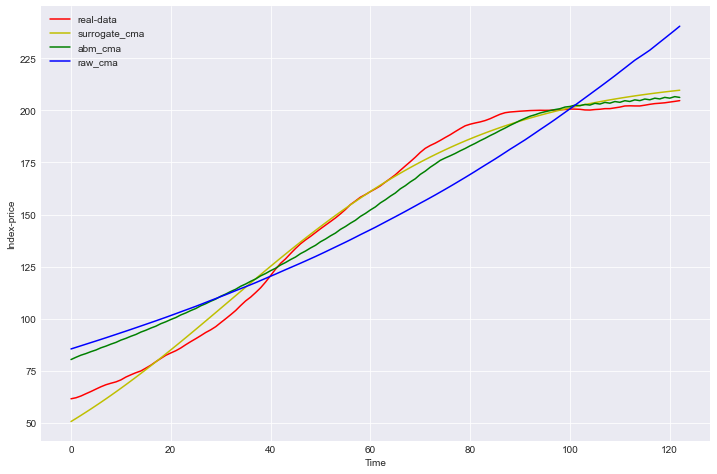

In [14]:
def main():

    average_price = 0
    sold = 0
    sum_price = 0
    sold_price = 0


    buyers = []
    sellers = []
    best_mrse = 0
    best_sim = []
    realdata = readData("sp")
    t = len(realdata)
    
    #Initializing the parameters with most plausiblre values
    price0= min(realdata)
    limit = max(realdata)
    alpha = 0.05
    beta = 0.03
    price_time_series = [price0]
    
#normalizing values as price0 and limit are orders of magnitude greater than alpha and beta parameters
    price0_norm = math.fabs(deconverse(price0, 65))
    limit_norm = math.fabs(deconverse(limit, 210))
    sigma=[price0_norm, alpha, beta, limit_norm]
    
    len_noise = 4
    noise = []
    for i in range(len_noise):
        x = np.random.random_sample()
        noise.append(x)
        

    
    
#Find best parameters for the ODE based on real data - CMA-ES strategy
    surrogate_simulator = DESimulator(realdata)
    cma_surrogate_data = surrogate_simulator.run(sigma=[price0_norm, alpha, beta, limit_norm], sigma0=0.02)
    cma_surrogate_data = [converse(cma_surrogate_data[0], 65), cma_surrogate_data[1], cma_surrogate_data[2], converse(cma_surrogate_data[3], 210)]
    #print(f"Params: {cma_surrogate_data}")
    best_cma_surrogate_sim = surrogate_simulator.simulate(cma_surrogate_data, t)
    #print(f"Best Sim: {best_cma_surrogate_sim}")
    rmse_cma_surrogate = math.sqrt(mean_squared_error(best_cma_surrogate_sim, realdata))
    #print(f"Best RMSE MCMA_Surrogate: {rmse_cma_surrogate}")
    
    #Find best parameters for agent-based model after calibrating surrogate with CMA-ES strategy
    mas_surrogate_cma_simulator = ABSimulator(realdata)
    cma_surrogate_data.append(0.2)
    cma_surrogate_data.append(3)
    mas_surrogate_cma_data = mas_surrogate_cma_simulator.calibrate(sigma = cma_surrogate_data, sigma0=0.02)
    #print(f"Params cam_mas: {mas_surrogate_cma_data}")
    #print("Best sim: {}".format(mas_surrogate_cma_simulator.best_sim))
    
    #Find best parameters for the raw agent-based model with CMA-ES - without using the surrogate
    raw_cma_simulator = ABSimulator(realdata)
    lower_b = 0.2
    noSell = 3
    raw_cma_data = raw_cma_simulator.calibrate(sigma=[price0_norm, np.random.randint(1, 11)/100, np.random.randint(1, 11)/100, limit_norm, lower_b, noSell], sigma0=0.02)
    #print(f"Params raw_mas: {converse(raw_cma_data[0], 65), raw_cma_data[1], raw_cma_data[2], converse(raw_cma_data[3], 210)}")
    
    
    
    rmse_cma_surrogate = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    rmse_cma_raw = math.sqrt(mean_squared_error(raw_cma_simulator.best_sim, realdata))
    rmse_cma_mas = math.sqrt(mean_squared_error(mas_surrogate_cma_simulator.best_sim, realdata))
    
    #print("***********************************")
    #print(f'Raw: {rmse_cma_raw} | MAS: {rmse_cma_surrogate}')
    
    
            
        
    #Print results 
    plt.figure(figsize=(12,8))
    t = range(0,123)
    plt.style.use('seaborn-darkgrid')
    plt.xlabel('Time')
    plt.ylabel('Index-price')
    plt.plot(t, realdata, "r", label='real-data')
    plt.plot(t, best_cma_surrogate_sim,"y", label='surrogate_cma')
    plt.plot(t, mas_surrogate_cma_simulator.best_sim, "g", label='abm_cma')
    plt.plot(t,raw_cma_simulator.best_sim, "b", label='raw_cma')
    #plt.plot(t,raw_mc_simulator.best_sim, "y-", label='raw_mc' )
    #plt.plot(t,best_mc_surrogate_sim, "y-", label='surrogate_mc' )
    #plt.plot(t,mas_mc_simulator.best_sim, "g", label='abm_mc')
    #plt.plot(t,raw_mc_simulator.best_sim, "b", label='raw_mc')
    plt.legend()
    #plt.show()
    
    with open('cma_surrogate_random', 'a') as f:
        f.write(str(realdata) + "; " + str(mas_surrogate_cma_simulator.best_sim)+ ";"+  str(raw_cma_simulator.best_sim) + ";"+ str(rmse_cma_mas) + ";" + str(rmse_cma_raw) +"\n")

    
    
    
    


    
if __name__ == "__main__":
    main()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1059499, Fri Oct 28 01:50:40 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1000812, Fri Oct 28 01:50:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.656770295982371e+01 1.0e+00 1.90e-02  2e-02  2e-02 0:00.0
    2     16 1.035300373654083e+01 1.3e+00 1.82e-02  2e-02  2e-02 0:00.0
    3     24 8.204339536631798e+01 1.5e+00 1.95e-02  2e-02  3e-02 0:00.0
  100    800 4.668275683296327e+00 2.9e+03 4.72e-03  4e-05  9e-03 0:00.8
  200   1600 4.668268327544604e+00 5.2e+04 4.23e-06  1e-09  3e-06 0:01.7
NOTE (module=cma, iteration=236):  
condition in coordinate system exceeded 1.4e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+11 to 1.1e+06
  300   2400 4.668268327512646e+00 1.8e+03 2.04e-05  2e-09  1e-05 0:02.7
  400   3200 4.668268327544821e+00 8.9e+03 3.12e-06  4e-11  1e-06 0:03.3
  500   4000 4.668268327544803e+00 9.1e+03 2.83e-06  1e-11  2e-07 0:04.1
  550   4400 

    2     18 3.674154269001175e+01 1.2e+00 2.67e-02  3e-02  3e-02 0:00.5
    3     27 3.411201676362042e+01 1.4e+00 2.83e-02  3e-02  3e-02 0:00.7
   24    216 3.636991444248940e+01 7.3e+00 1.74e-02  4e-03  2e-02 0:03.8
   53    477 3.394565401838327e+01 4.3e+01 2.35e-02  9e-04  3e-02 0:07.8
   93    837 3.085598235539441e+01 2.4e+03 3.27e-01  7e-04  9e-01 0:12.9
  100    900 3.041254694463852e+01 3.6e+03 3.96e-01  6e-04  1e+00 0:13.6
NOTE (module=cma, iteration=117):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 3.3e+08 to 7.9e+02
  160   1440 1.144459314651706e+01 3.6e+01 1.76e+00  3e-04  7e+00 0:20.6
  200   1800 1.499566686515465e+01 5.2e+01 9.18e-01  1e-04  3e+00 0:25.8
  273   2457 1.509538110808730e+01 1.4e+02 4.35e-01  7e-05  2e+00 0:34.9
  300   2700 1.345801000729381e+01 2.6e+02 3.66e-01  7e-05  2e+00 0:38.7
  398   3582 1.372762810975973e+01 4.6e+02 1.39e+00  1e-04  3e+00 0:49.8
  400   3600 1.209707741413624e+01 5.1e+02 1.86e

    2     18 2.030368737189833e+01 1.2e+00 1.89e-02  2e-02  2e-02 0:00.3
    3     27 1.151734435723711e+01 1.3e+00 1.90e-02  2e-02  2e-02 0:00.4
   28    252 9.902621182221795e+00 1.1e+01 4.55e-03  7e-04  6e-03 0:03.5
   62    558 9.816659001649047e+00 2.7e+01 3.28e-03  2e-04  5e-03 0:07.6
  100    900 9.767182195839387e+00 5.6e+01 1.86e-03  7e-05  3e-03 0:12.3
  150   1350 9.826506683275646e+00 1.4e+02 4.77e-04  1e-05  6e-04 0:18.3
  200   1800 9.850972518496715e+00 2.4e+02 2.12e-04  4e-06  2e-04 0:24.3
  268   2412 9.710947928340495e+00 3.5e+02 2.33e-04  4e-06  2e-04 0:32.4
  300   2700 9.734562922713655e+00 4.0e+02 2.72e-04  3e-06  1e-04 0:36.3
  384   3456 9.825599157847734e+00 1.1e+03 4.76e-04  1e-05  2e-04 0:46.4
  400   3600 9.869017595980832e+00 1.7e+03 3.01e-04  6e-06  2e-04 0:48.3
  500   4500 1.004662447646240e+01 6.3e+03 1.09e-03  1e-05  4e-04 1:00.3
  505   4545 9.821147620886265e+00 6.3e+03 1.31e-03  2e-05  4e-04 1:00.9
termination on tolstagnation=263 (Fri Oct 28 01:58:

    1      8 1.085300817739360e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.0
    2     16 2.582554700375172e+01 1.2e+00 1.72e-02  1e-02  2e-02 0:00.0
    3     24 1.964801883011497e+01 1.4e+00 1.64e-02  1e-02  2e-02 0:00.0
  100    800 4.668269971986015e+00 1.2e+03 1.15e-03  9e-06  1e-03 0:00.5
  200   1600 4.668268327544693e+00 3.4e+04 2.60e-06  9e-10  9e-07 0:01.1
  300   2400 4.668268327533931e+00 5.4e+04 1.01e-06  2e-10  4e-08 0:01.6
  400   3200 4.668268327544626e+00 4.4e+05 2.74e-07  3e-11  6e-09 0:02.1


/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=450)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327533904e+00 2.9e+01 7.45e-08  2e-08  1e-07 0:02.7
  505   4040 4.668268327533916e+00 3.3e+01 5.94e-08  2e-08  1e-07 0:02.7
termination on tolstagnation=200 (Fri Oct 28 02:01:14 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.4329711456353529, 0.03748920451042642, 0.03694443547488202, 0.3600220720375429]
std deviation: [3.7247428884507935e-08, 1.0385398903980758e-07, 2.9326609063076346e-08, 1.695722392535325e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1079647, Fri Oct 28 02:01:14 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1078956, Fri Oct 28 02:01:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.015491455523660e+01 1.0e+00 2.03e-02  2e-02  2e-02 0:00.2
    2     18 2.480476974859088e+01 1.3e+00 2.07e-02  2e-02  2e-02 0:00.3
    3     27 1.072959229585897e+01 1.4e+00 2.11e-02  2e-02  2e-02 0:00.4
   29    261 1.036159179439218e+01 9.4e+00 7.54e-03  1e

termination on tolstagnation=263 (Fri Oct 28 02:05:57 2022)
final/bestever f-value = 3.402445e+01 3.394682e+01
incumbent solution: [0.4173340589973736, 0.04567715346260413, 0.004814184775420527, 0.44567171394273547, 0.2764691678354285, 3.0276457099475462]
std deviation: [0.0007125895672410116, 0.0014503342048414816, 4.6151094347960325e-06, 0.0013879634311322081, 5.585017128951482e-05, 0.0006780078198943563]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1078005, Fri Oct 28 02:05:57 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1025212, Fri Oct 28 02:05:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.708853529356274e+01 1.0e+00 1.98e-02  2e-02  2e-02 0:00.0
    2     16 1.630191985021825e+01 1.3e+00 1.65e-02  1e-02  2e-02 0:00.0
    3     24 2.010848396337776e+01 1.4e+00 1.31e-02  1e-02  1e-02 0:00.0
  100    800 4.668268708721070e+00 4.2e+03 1.50e-03  8e-06  3e-03 0:00.5
NOTE (module=cma, iteration=158):  
conditi

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=463)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327555272e+00 6.1e+00 5.16e-07  3e-07  9e-07 0:02.7
  505   4040 4.668268327544570e+00 5.3e+00 3.12e-07  1e-07  4e-07 0:02.7
termination on tolstagnation=200 (Fri Oct 28 02:08:16 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.432971318072851, 0.037489206037020335, 0.034365033457532224, -1.1313018172287737]
std deviation: [1.4807669072964773e-07, 4.313905360509783e-07, 1.9102226294383698e-07, 1.858160274304807e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1094466, Fri Oct 28 02:08:16 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1074546, Fri Oct 28 02:08:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.354172305256263e+01 1.0e+00 1.95e-02  2e-02  2e-02 0:00.2
    2     18 1.813702095550837e+01 1.3e+00 1.85e-02  2e-02  2e-02 0:00.3
    3     27 1.269462666227458e+01 1.4e+00 1.77e-02  2e-02  2e-02 0:00.4
   30    270 1.196012498781353e+01 8.3e+00 9.37e-03  1

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=484)
  warnings.warn(msg + ' (' +


  600   4800 4.668268327555299e+00 6.0e+01 5.23e-06  2e-06  7e-06 0:03.2
  615   4920 4.668268327533902e+00 5.8e+01 6.73e-06  2e-06  8e-06 0:03.3
termination on tolstagnation=200 (Fri Oct 28 02:10:29 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.4329713436924862, 0.03748920641376924, 0.03584259978489257, -0.27702327576753305]
std deviation: [3.510012414526802e-06, 1.947710350118984e-06, 2.485485108308928e-06, 7.595062320117182e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=963701, Fri Oct 28 02:10:29 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1004773, Fri Oct 28 02:10:29 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.290698454504605e+01 1.0e+00 1.80e-02  2e-02  2e-02 0:00.2
    2     18 2.306110911616594e+01 1.2e+00 1.89e-02  2e-02  2e-02 0:00.3
    3     27 1.028769918083087e+01 1.5e+00 2.24e-02  2e-02  3e-02 0:00.4
   28    252 1.034728213369868e+01 5.8e+00 1.69e-02  5e-0

  300   2700 1.277369267734443e+01 1.2e+02 5.89e-01  8e-05  2e+00 0:28.4
  400   3600 1.143619738566355e+01 1.7e+02 4.55e-01  7e-05  5e-01 0:37.5
  500   4500 1.428756012506944e+01 1.7e+03 1.48e-01  3e-05  3e-01 0:46.5
  505   4545 1.457251689475845e+01 1.6e+03 1.18e-01  2e-05  2e-01 0:47.0
termination on tolstagnation=263 (Fri Oct 28 02:14:46 2022)
final/bestever f-value = 1.495209e+01 1.113084e+01
incumbent solution: [51.68402445421098, -8.241029506841652, 0.0030350194490911227, -17.10341810708572, 16.1670294824631, -16.24679485865099]
std deviation: [0.11750766540994997, 0.029325300685777992, 2.0910426406245994e-05, 0.23558184453401312, 0.08253035580250802, 0.07181185248221766]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=967342, Fri Oct 28 02:14:46 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=949791, Fri Oct 28 02:14:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.377709461641572e+01 1.0e+00 1.87e-02  2e-02

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=489)
  warnings.warn(msg + ' (' +


  600   4800 4.668268327533889e+00 1.2e+01 6.01e-06  5e-07  3e-06 0:03.2
  700   5600 4.668268327533890e+00 1.3e+01 5.21e-06  2e-07  3e-07 0:03.7
  730   5840 4.668268327533889e+00 2.6e+01 9.20e-06  3e-07  5e-07 0:03.9
termination on tolstagnation=200 (Fri Oct 28 02:16:40 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.4329711855641278, 0.037489205182954066, 0.03597799403572566, -0.19874209958288702]
std deviation: [4.926801462422723e-07, 4.0824862483186174e-07, 2.512811921929706e-07, 4.642756739429755e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1036195, Fri Oct 28 02:16:40 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=952781, Fri Oct 28 02:16:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.027296803705825e+01 1.0e+00 2.03e-02  2e-02  2e-02 0:00.1
    2     18 1.062672792924472e+01 1.3e+00 2.40e-02  2e-02  3e-02 0:00.3
    3     27 1.218028492338123e+01 1.5e+00 2.71e-02  2e

    1      8 5.196630510964699e+01 1.0e+00 1.75e-02  2e-02  2e-02 0:00.0
    2     16 9.439634944966423e+00 1.3e+00 1.69e-02  2e-02  2e-02 0:00.0
    3     24 1.690101768472456e+01 1.5e+00 1.64e-02  1e-02  2e-02 0:00.0
  100    800 4.668271712056415e+00 1.6e+03 1.29e-03  8e-06  1e-03 0:00.5
  200   1600 4.668268327539689e+00 1.4e+04 1.54e-05  5e-09  7e-06 0:01.0
  300   2400 4.668268327534324e+00 4.2e+04 1.27e-05  2e-09  3e-06 0:01.6
  400   3200 4.668268327555504e+00 3.8e+04 2.45e-05  6e-10  1e-06 0:02.2
  500   4000 4.668268327523344e+00 2.0e+05 1.14e-05  1e-10  2e-07 0:02.7
  600   4800 4.668268327544681e+00 2.6e+05 4.56e-05  2e-10  2e-07 0:03.2
  700   5600 4.668268327523278e+00 1.6e+00 3.00e-06  3e-06  4e-06 0:03.8


/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=697)
  warnings.warn(msg + ' (' +


  765   6120 4.668268327544679e+00 5.5e+01 5.24e-06  5e-06  1e-05 0:04.1
termination on tolstagnation=200 (Fri Oct 28 02:20:01 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.432971103087463, 0.037489205279630275, 0.037241293889721305, 0.5316549662993921]
std deviation: [4.876971351888243e-06, 1.3969984704796037e-05, 6.386650393299335e-06, 6.04557664040393e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1105694, Fri Oct 28 02:20:01 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1053607, Fri Oct 28 02:20:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.043621399789939e+01 1.0e+00 1.87e-02  2e-02  2e-02 0:00.2
    2     18 1.216005546388681e+01 1.2e+00 1.89e-02  2e-02  2e-02 0:00.3
    3     27 1.252197110837646e+01 1.4e+00 2.01e-02  2e-02  2e-02 0:00.4
   29    261 1.030503815717655e+01 4.5e+00 4.45e-03  1e-03  4e-03 0:03.4
   63    567 1.024159544081757e+01 1.6e+01 1.68e-03  2e-0

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=579)
  warnings.warn(msg + ' (' +


  650   5200 4.668268327544574e+00 1.5e+01 1.50e-06  5e-07  2e-06 0:03.6
termination on tolstagnation=200 (Fri Oct 28 02:22:25 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.4329713075931068, 0.037489206234800676, 0.03633215723095873, 0.006022347777616233]
std deviation: [7.84622944129037e-07, 1.3586942339616326e-06, 4.570375792946021e-07, 1.73694098596471e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1050656, Fri Oct 28 02:22:26 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=951086, Fri Oct 28 02:22:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.237951614565735e+01 1.0e+00 2.09e-02  2e-02  2e-02 0:00.2
    2     18 1.085342324255218e+01 1.4e+00 2.11e-02  2e-02  2e-02 0:00.3
    3     27 1.365756713555846e+01 1.5e+00 2.35e-02  2e-02  3e-02 0:00.4
   29    261 1.025269556344251e+01 6.1e+00 1.33e-02  6e-03  2e-02 0:03.5
   63    567 9.848419267209033e+00 4.7e+01 6.69e-03  4e-0

  700   6300 1.092212438841113e+01 4.7e+04 5.34e-03  2e-07  1e-02 1:20.8
  710   6390 1.227905928106683e+01 4.9e+04 6.43e-03  2e-07  1e-02 1:22.1
termination on tolstagnation=263 (Fri Oct 28 02:26:48 2022)
final/bestever f-value = 1.431102e+01 7.129804e+00
incumbent solution: [63.09544362992324, 102.58846125123254, 0.0026970547088904845, -39.53086881455286, 106.46800681114163, -70.24023801966563]
std deviation: [0.00631119494631324, 0.010192607289569843, 2.1437061930609275e-07, 0.003594694780959642, 0.010589920940360159, 0.008213637692575737]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1013690, Fri Oct 28 02:26:48 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1049319, Fri Oct 28 02:26:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.190095587012916e+01 1.0e+00 2.29e-02  2e-02  3e-02 0:00.0
    2     16 2.098074562993814e+01 1.3e+00 2.22e-02  2e-02  2e-02 0:00.0
    3     24 2.640796078001359e+01 1.3e+00 1.72e-02

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=461)
  warnings.warn(msg + ' (' +


  500   4000 4.668268327544592e+00 4.3e+00 1.82e-05  9e-06  1e-05 0:02.7
  565   4520 4.668268327544584e+00 1.3e+01 8.03e-06  1e-06  3e-06 0:03.1
termination on tolstagnation=200 (Fri Oct 28 02:29:23 2022)
final/bestever f-value = 4.668268e+00 4.668268e+00
incumbent solution: [-1.432971251461199, 0.03748920558994803, 0.03733836537361665, 0.5877782113744789]
std deviation: [2.5974293406900418e-06, 2.503103073182745e-06, 2.598525714122109e-06, 1.3998848442749336e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1043455, Fri Oct 28 02:29:23 2022)
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=994652, Fri Oct 28 02:29:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.574142521171734e+01 1.0e+00 2.19e-02  2e-02  2e-02 0:00.1
    2     18 1.282915171118192e+01 1.4e+00 2.05e-02  2e-02  2e-02 0:00.3
    3     27 1.101017424200175e+01 1.4e+00 1.94e-02  2e-02  2e-02 0:00.4
   30    270 1.097646877736636e+01 3.7e+00 1.18e-02  5e-03

/Users/priscillaavegliano/opt/anaconda3/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=497)
  warnings.warn(msg + ' (' +


  500   4500 1.861316302174710e+01 1.4e+00 1.17e-01  1e-01  1e-01 0:45.5
  505   4545 1.859733927791350e+01 1.8e+00 1.10e-01  9e-02  1e-01 0:45.9
termination on tolstagnation=263 (Fri Oct 28 02:31:07 2022)
final/bestever f-value = 1.876364e+01 1.858551e+01
incumbent solution: [44.134342136722395, 1.1322700980714728, 0.00880259757962129, -15.228659097550917, 0.8201154026968922, 3.572796951371359]
std deviation: [0.1056010833938298, 0.10350901730735766, 0.09339117863949124, 0.10346716036772731, 0.11617693381652398, 0.11850327070717206]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1041027, Fri Oct 28 02:31:07 2022)
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1052021, Fri Oct 28 02:31:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.109573603559272e+01 1.0e+00 1.83e-02  2e-02  2e-02 0:00.0
    2     16 1.606545492276994e+01 1.2e+00 1.66e-02  2e-02  2e-02 0:00.0
    3     24 1.922690665443946e+01 1.2e+00 1.47e-02  1e-02  

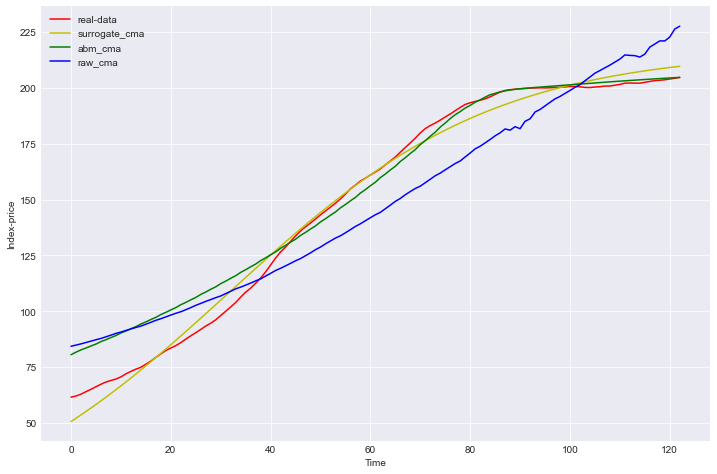

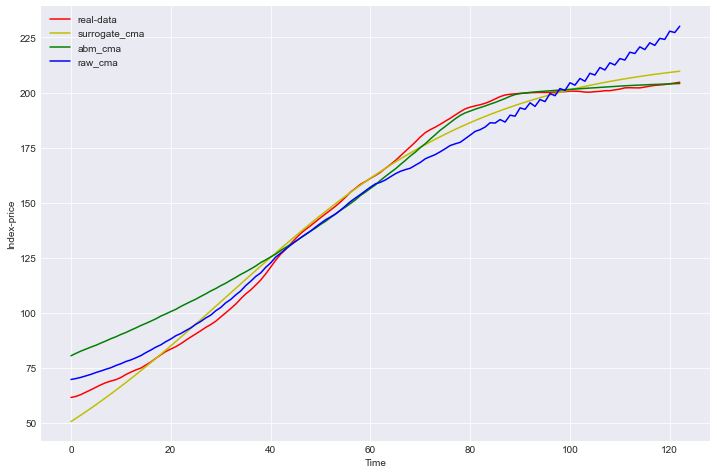

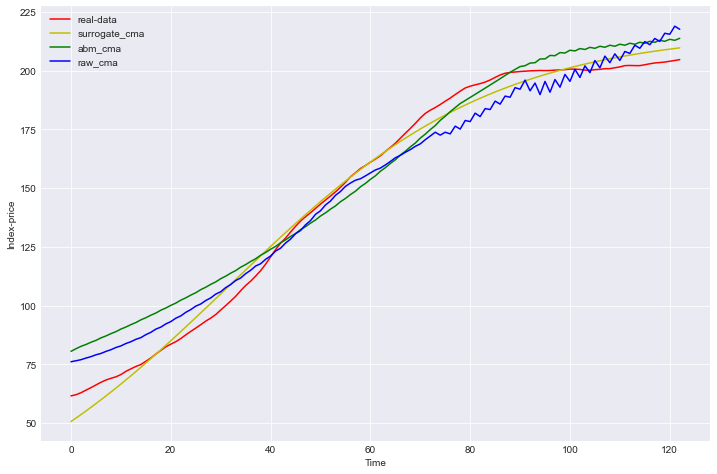

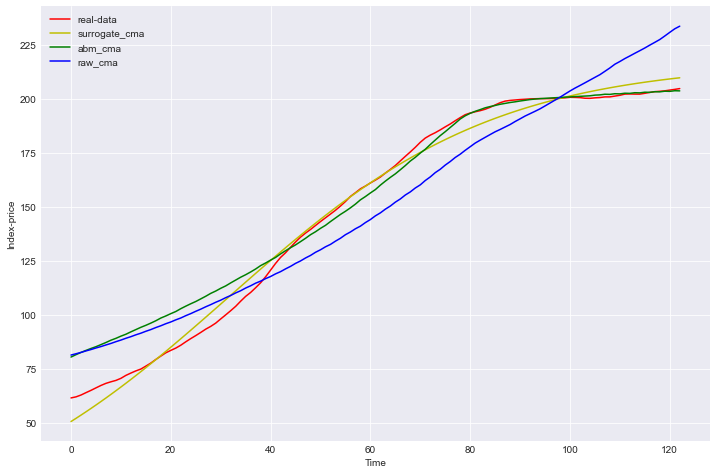

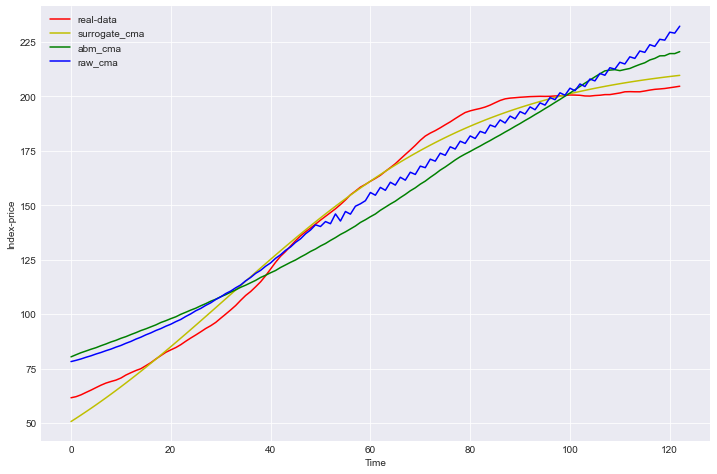

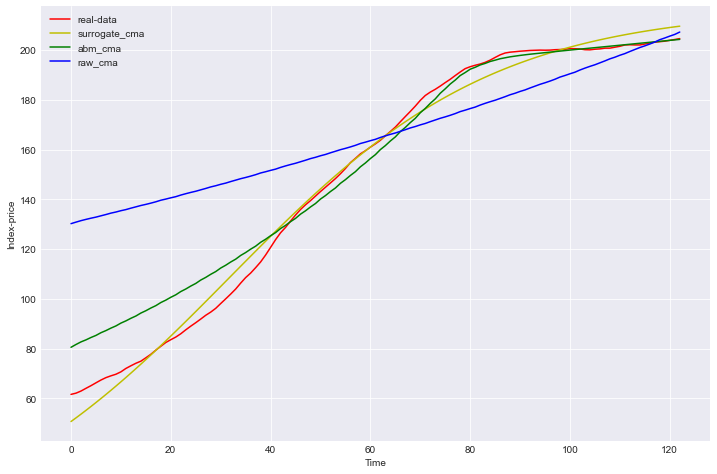

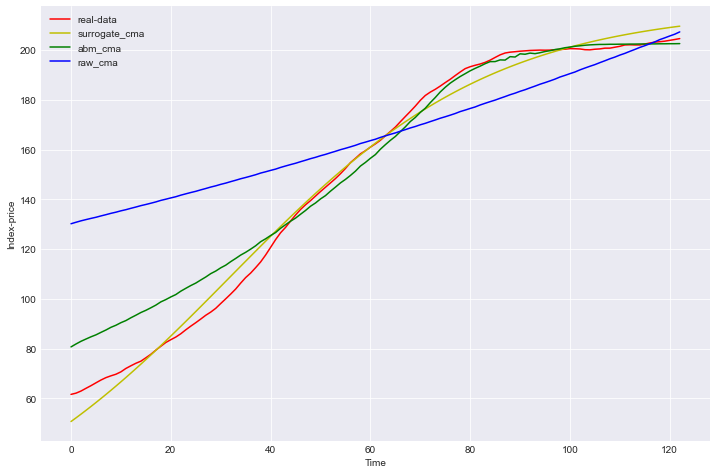

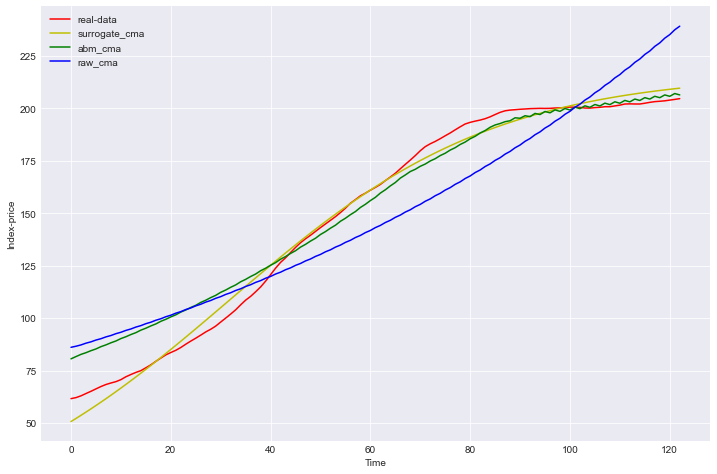

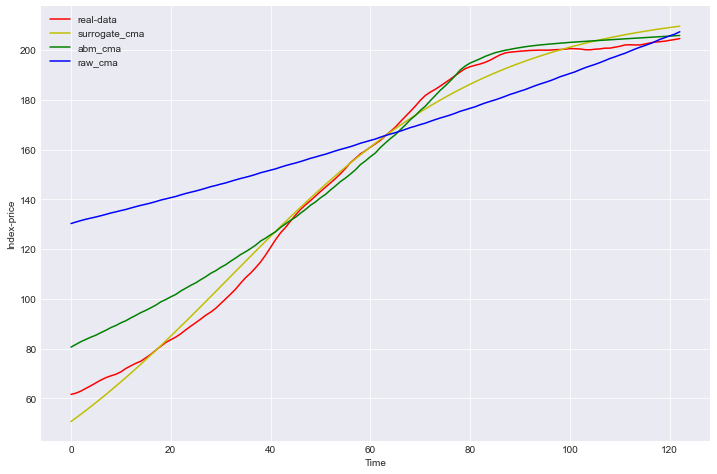

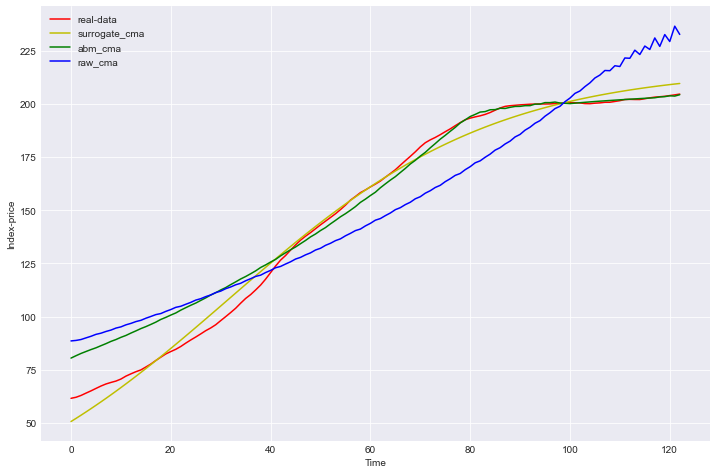

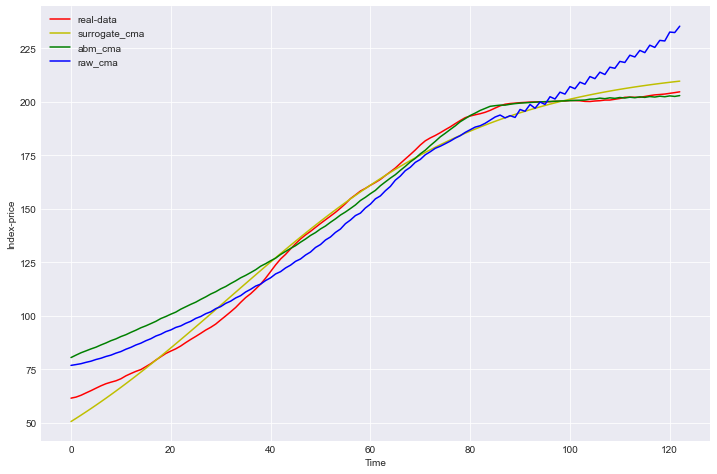

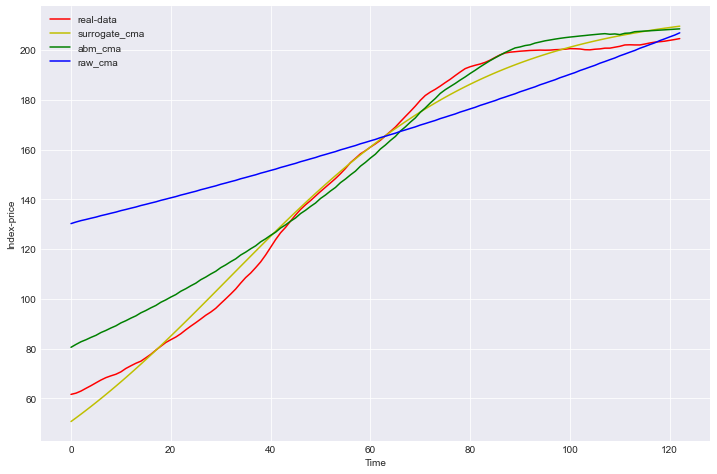

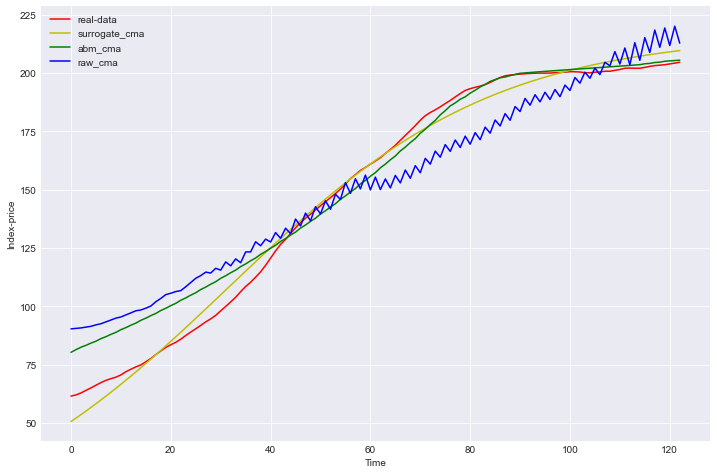

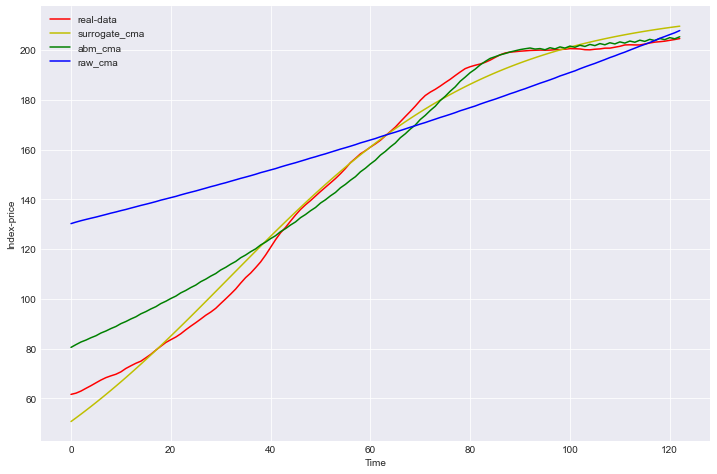

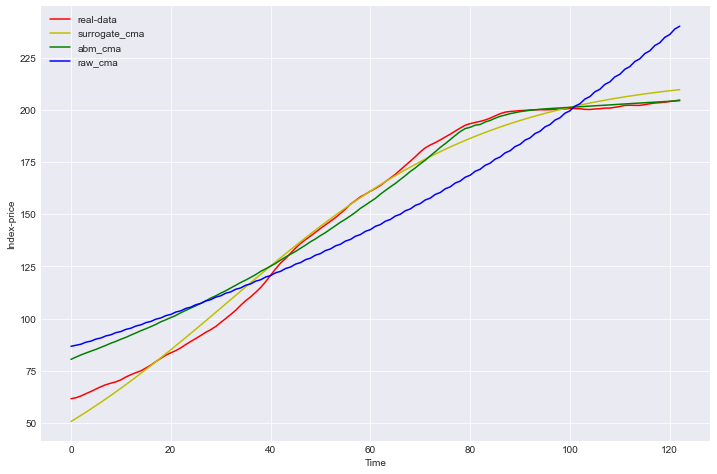

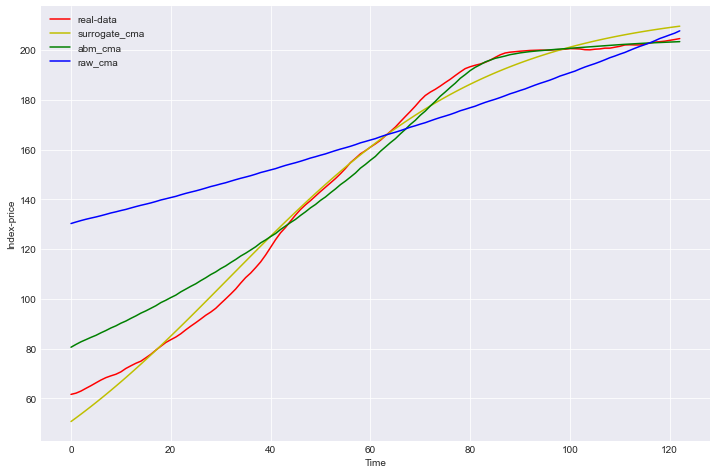

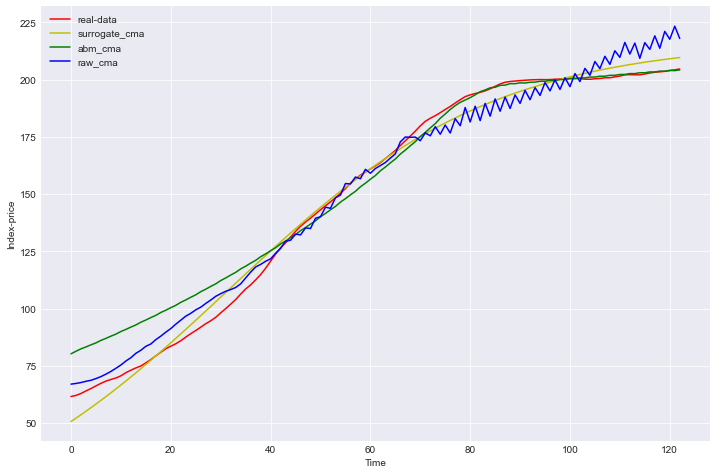

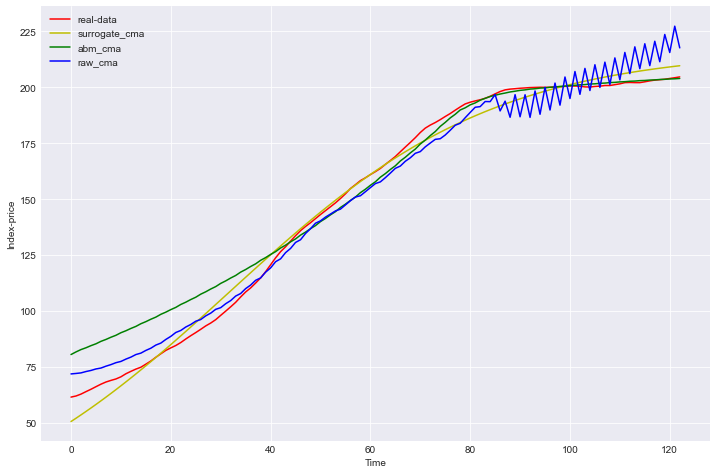

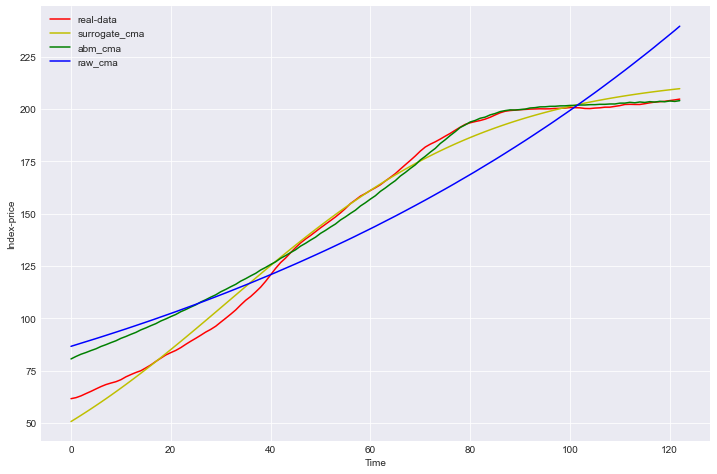

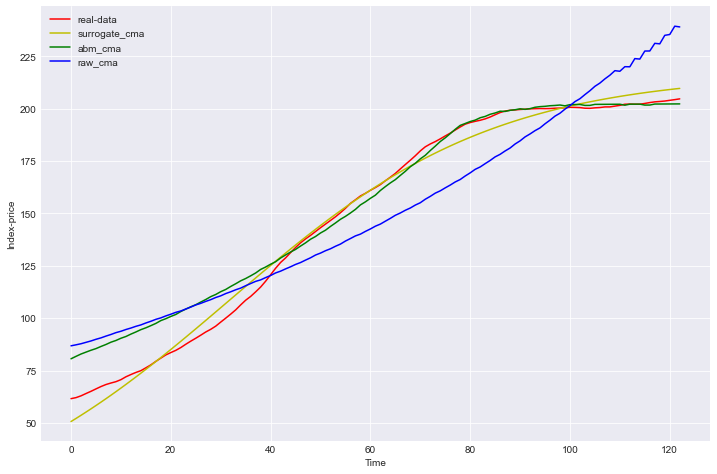

In [18]:
for i in range(20):
    main()